### Initialize Database Connection and Load the Data

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import os
import sys
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display

In [5]:
from home_messages_db import HomeMessagesDB

db = HomeMessagesDB('sqlite:///myhome.db')

# Load the data
df_smartthings = db.get_smartthings()
df_weather = db.get_weather_data()

### Prepare the Data 

In [7]:
# Convert epoch time to datetime in df_smartthings and df_weather
df_smartthings['datetime'] = pd.to_datetime(df_smartthings['epoch'], unit='s')
df_weather['datetime'] = pd.to_datetime(df_weather['time'], unit='s')

# Extract weekends from the datetime
df_smartthings['is_weekend'] = df_smartthings['datetime'].dt.weekday >= 5
df_weather['is_weekend'] = df_weather['datetime'].dt.weekday >= 5

# Filter data to focus on motion detection events
motion_df = df_smartthings[df_smartthings['capability'] == 'motionSensor']
motion_df = motion_df[motion_df['value'] == 'active']

# Merge the two datasets on the nearest datetime to align weather data with motion events
merged_df = pd.merge_asof(
    motion_df.sort_values('datetime'),
    df_weather.sort_values('datetime'),
    on='datetime',
    direction='nearest'
)

# Filter merged data to only include weekends
weekend_df = merged_df[merged_df['is_weekend_x']]


### Calculate Descriptives 

In [53]:
# Calculate descriptive statistics for key weather variables on weekends
weather_stats = weekend_df[['temperature_2m', 'relativehumidity_2m', 'rain']]


# Calculate the number of motion events per weekend day
weekend_df['date'] = weekend_df['datetime'].dt.date
motion_counts = weekend_df.groupby('date').size().reset_index(name='motion_count')

# Calculate daily weather averages
daily_weather = weekend_df.groupby('date')[['temperature_2m', 'rain']].mean().reset_index()

# Merge the motion counts back with the weather data for the corresponding dates
motion_weather_df = pd.merge(motion_counts, daily_weather, on='date')

stats = motion_weather_df.describe()


# Display the merged data
display(stats)


/var/folders/z1/762t94_j4tx1bhtk_g1t9qh80000gn/T/ipykernel_28142/2703015128.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_df['date'] = weekend_df['datetime'].dt.date


,motion_count,temperature_2m,rain
count,107.000000,107.000000,107.000000
mean,284.327103,12.052548,0.110797
std,109.400922,6.302658,0.188755
min,2.000000,-1.298233,0.000000
25%,239.500000,7.933590,0.000000
50%,304.000000,12.261290,0.024074
75%,353.000000,16.826479,0.121696
max,551.000000,24.322590,0.890393


Looking at the descriptive statistics, we cann see that the average amount of movement over the investigated time period was about 284 movements per day on the weekend, with an average outside temperature of around 12 degrees celcius and an average rainfall of 0.11mm.

# Check assumptions for regression analysis

We want to check how our response is distributed to choose an appropriate model. Since we deal with count data it is reasonable that the response follows a poisson distribution. We would expect equal mean and variance for this.

In [31]:
import numpy as np

#response
counts = np.array(motion_weather_df['motion_count'])

mean = np.mean(counts)
variance = np.var(counts)

print(f"Mean: {mean}, Variance: {variance}")


Mean: 284.32710280373834, Variance: 11856.706087867937


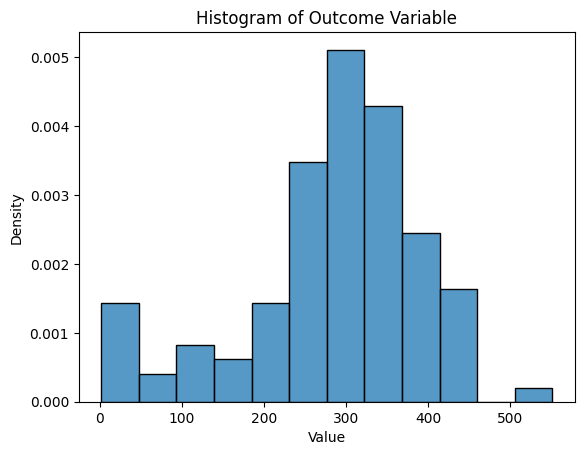

In [32]:

# Plot histogram
sns.histplot(counts, kde=False, stat="density")
plt.title('Histogram of Outcome Variable')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


The mean and variance is not the same for our data. Plotting a histogram of the response we see that the distribution looks rather normal. But visually, it could still be plausable that it follows a poisson distribution. Let us do a chi-squared goodness-of-fit test, and compare the observed count frequencies against the expected frequences of a poisson pmf.

In [34]:
from scipy.stats import chisquare
import scipy.stats as stats

# Frequencies of observed data
observed_freq = np.bincount(counts)
# Frequencies of expected data
expected_freq = [stats.poisson.pmf(i, mean) * len(counts) for i in range(len(observed_freq))]

# Chi-square test
chi2_stat, p_val = chisquare(observed_freq, expected_freq)
print(f"Chi2 Statistic: {chi2_stat}, p-value: {p_val}")


Chi2 Statistic: 7.083694716474201e+116, p-value: 0.0


We can reject the null hypothesis that the data follow a poisson distribution. Let us see if the reponse follows a normal distribution.

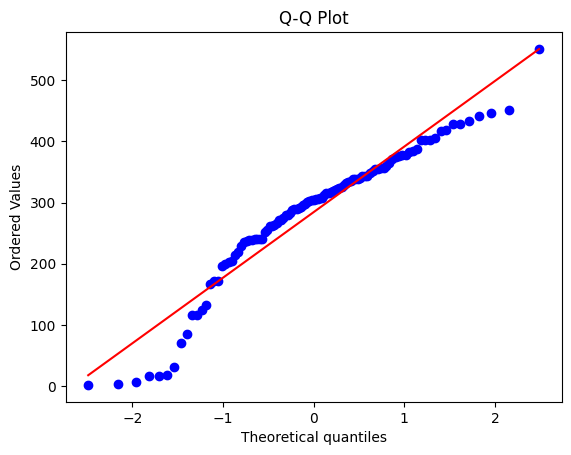

Shapiro-Wilk Test Statistic: 0.9325094223022461, p-value: 3.893504253937863e-05


In [35]:
# Q-Q plot
stats.probplot(counts, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk test
shapiro_stat, shapiro_p_value = stats.shapiro(counts)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_p_value}")


Looking at the QQ-plot we can see that it appears that the response significantly deviates from a normal distribution. The Q-Q plot shows a noticeable departure from the reference line, particularly at both ends, indicating heavy tails or skewness that is not characteristic of a normal distribution. Furthermore, the Spapiro-Wilk test turned out to be highly significant, which means that we have to reject the null hypothesis that the response follows a normal distribution. To finally decide wether the reponse follows a poisson or another distribution for count data (e.g. the negative binomial distribution), let us look at the likelihood functions for those distributions given the data.

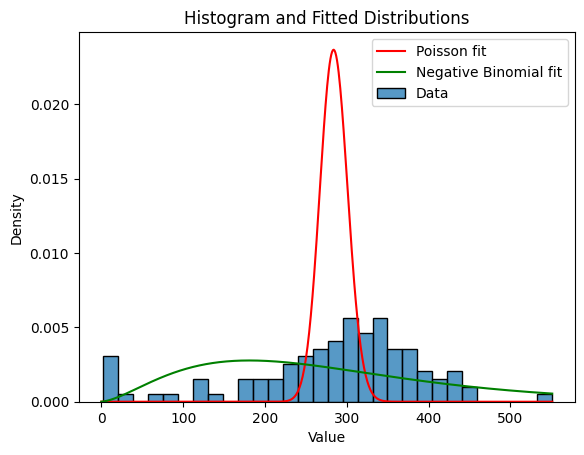

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import minimize


# Fit Poisson distribution
poisson_lambda = np.mean(counts)
poisson_fit = stats.poisson(mu=poisson_lambda)

# Define negative binomial log-likelihood function
def neg_binom_log_likelihood(params, counts):
    r, p = params
    return -np.sum(stats.nbinom.logpmf(counts, r, p))

# Initial guess for the parameters
initial_params = [1, 0.5]

# Fit Negative Binomial distribution
result = minimize(neg_binom_log_likelihood, initial_params, args=(counts,), bounds=((1e-5, None), (1e-5, 1-1e-5)))
neg_binom_r, neg_binom_p = result.x

# Plot histogram and fitted distributions
sns.histplot(counts, bins=30, kde=False, stat="density", label="Data")
x = np.arange(0, max(counts)+1)
plt.plot(x, poisson_fit.pmf(x), 'r-', label='Poisson fit')
plt.plot(x, stats.nbinom.pmf(x, neg_binom_r, neg_binom_p), 'g-', label='Negative Binomial fit')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram and Fitted Distributions')
plt.show()


In [44]:
from scipy.stats import chi2_contingency
# Calculate observed frequencies
observed_freq = np.bincount(counts)

# Calculate expected frequencies using the fitted negative binomial distribution
max_val = max(counts)
expected_freq = [stats.nbinom.pmf(i, neg_binom_r, neg_binom_p) * len(counts) for i in range(max_val + 1)]

# Adjust expected frequencies for any zero frequencies in the observed data
observed_nonzero = observed_freq > 0
observed_freq = observed_freq[observed_nonzero]
expected_freq = np.array(expected_freq)[observed_nonzero]

# Perform Chi-square goodness-of-fit test
chi2_stat, p_val = chi2_contingency([observed_freq, expected_freq])[:2]
print(f"Chi2 Statistic: {chi2_stat}, p-value: {p_val}")


Chi2 Statistic: 3.0905309585441, p-value: 1.0


Based on the fitting of the likelihood functions for the poisson and negative binomial given our data and the goodness of fit test for the negative binomial distribution we can see that our data likely follows a negative binomial distribution.

### Make Scatterplot and Fit Regression Line 

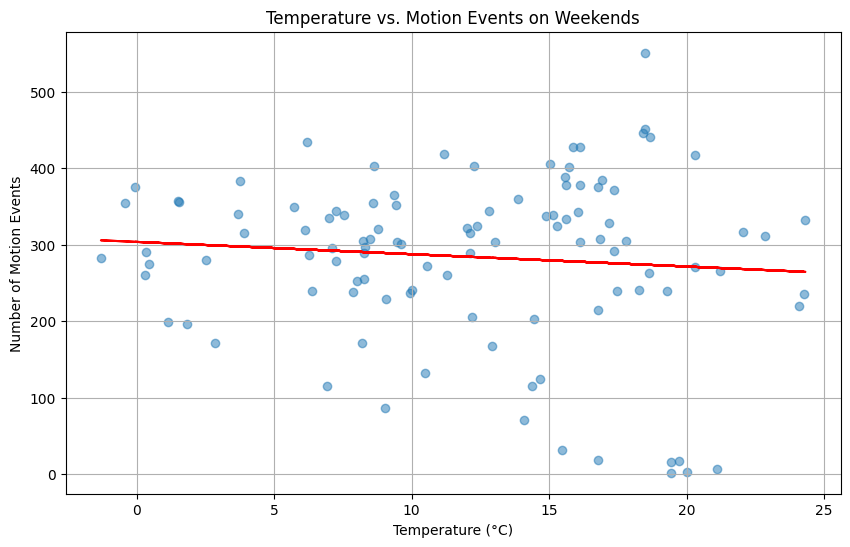

In [54]:
# Scatter plot for temperature vs. motion events
plt.figure(figsize=(10, 6))
plt.scatter(motion_weather_df['temperature_2m'], motion_weather_df['motion_count'], alpha=0.5)
plt.title('Temperature vs. Motion Events on Weekends')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Motion Events')

# fitting a linear regression line
m, b = np.polyfit(motion_weather_df['temperature_2m'], motion_weather_df['motion_count'], 1)

# adding the regression line to the scatter plot
plt.plot(motion_weather_df['temperature_2m'], m*motion_weather_df['temperature_2m'] + b, color='red')
plt.grid(True)
plt.show()

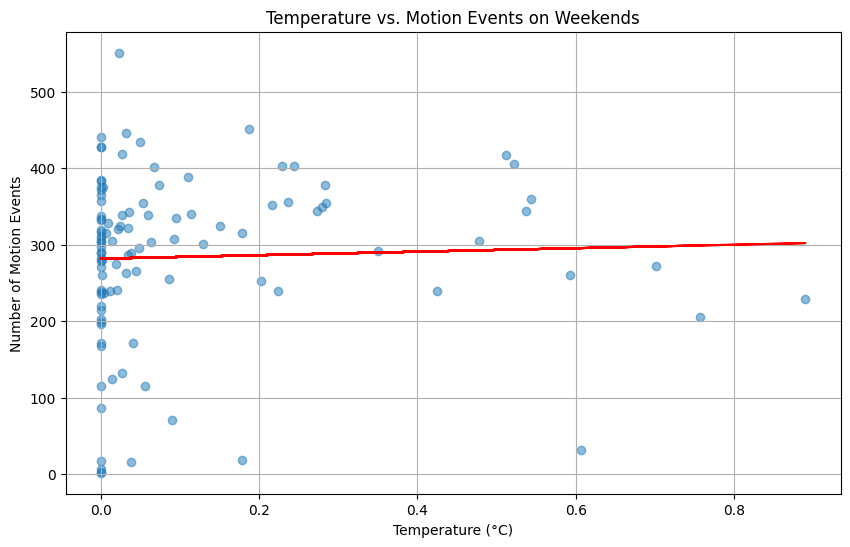

In [55]:
# Scatter plot for temperature vs. motion events
plt.figure(figsize=(10, 6))
plt.scatter(motion_weather_df['rain'], motion_weather_df['motion_count'], alpha=0.5)
plt.title('Temperature vs. Motion Events on Weekends')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Motion Events')

# fitting a linear regression line
m, b = np.polyfit(motion_weather_df['rain'], motion_weather_df['motion_count'], 1)

# adding the regression line to the scatter plot
plt.plot(motion_weather_df['rain'], m*motion_weather_df['rain'] + b, color='red')
plt.grid(True)
plt.show()

### Perform Regression Analysis

In [49]:
# Define the model formula
formula = 'motion_count ~ temperature_2m + rain'

# Fit the model
model = smf.negativebinomial(formula, motion_weather_df).fit()

# Display the model summary
print(model.summary())


Optimization terminated successfully.
         Current function value: 6.440244
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
                     NegativeBinomial Regression Results                      
Dep. Variable:           motion_count   No. Observations:                  107
Model:               NegativeBinomial   Df Residuals:                      104
Method:                           MLE   Df Model:                            2
Date:                Thu, 06 Jun 2024   Pseudo R-squ.:               0.0003338
Time:                        16:37:01   Log-Likelihood:                -689.11
converged:                       True   LL-Null:                       -689.34
Covariance Type:            nonrobust   LLR p-value:                    0.7944
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.7097     

Performing a negative binomial regression we can see that there is no significant association between the outside temperature 2 meters above the ground level and the measured outside rain and the movement in the house based on the motion sensor counts across all devices and rooms in the house on the weekends in the investigated time period.